# **Libraries**

In [2]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs
#!pip install tf-keras
#!pip install keras


import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz


import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from keras import layers
from keras import Sequential
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy


# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

  Preparing metadata (setup.py) ... done


# **Data-Set**

In [4]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'


# **Extracting Data_Set**

In [5]:
def list_files_from_zip_url(zip_url):

  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [6]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [7]:
def get_class(fname):
  return fname.split('_')[-3]

def get_files_per_class(files):

  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def select_subset_of_classes(files_for_class, classes, files_per_class):

  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset


def download_from_zip(zip_url, to_dir, file_names):

  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)


def split_class_lists(files_for_class, count):

  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder


def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):

  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

NUM_CLASSES = 10
FILES_PER_CLASS = 50

files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())




Num classes: 101
Num videos for class[0]: 145


['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

# **Saving in Directories**
## Making different folders for train, validation and test.

In [8]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 20, "val": 10, "test": 20},
                                       download_dir = download_dir)




train :


100%|██████████| 200/200 [00:40<00:00,  4.89it/s]


val :


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


test :


100%|██████████| 200/200 [00:30<00:00,  6.60it/s]


In [9]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


# **Formatting**

In [10]:
def format_frames(frame, output_size):

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


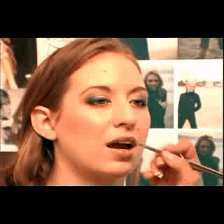

In [12]:
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

# **Building a Class**
## This is used to create an iterable object that can feed data for tensor pipeline.

In [13]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):

    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

# **Data Shape**

In [14]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 2


In [15]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)


for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)


# **Create Sets (train, validation, test)**

In [16]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [17]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [18]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [19]:
batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [20]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor([1 2 1 9 4 9 4 5], shape=(8,), dtype=int16)
tf.Tensor([7 0 8 4 6 4 5 5], shape=(8,), dtype=int16)
tf.Tensor([9 4 6 7 2 8 6 1], shape=(8,), dtype=int16)
tf.Tensor([8 6 5 6 6 4 3 1], shape=(8,), dtype=int16)
tf.Tensor([4 0 7 8 6 9 1 9], shape=(8,), dtype=int16)
tf.Tensor([1 8 7 3 0 4 4 3], shape=(8,), dtype=int16)
tf.Tensor([4 5 7 7 3 0 3 8], shape=(8,), dtype=int16)
tf.Tensor([5 7 9 3 1 3 6 5], shape=(8,), dtype=int16)
tf.Tensor([7 2 9 9 3 3 8 8], shape=(8,), dtype=int16)
tf.Tensor([0 9 4 1 5 8 9 1], shape=(8,), dtype=int16)


In [21]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (8, 8, 224, 224, 3)
Label: (8,)


# **Transfer Learning MoVinet**

In [22]:
!pip install -U -q "tf-models-official"
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 822.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 32.7 MB/s eta 0

# **Using Built-in Model**

In [23]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


# **Building a Classifier**
## Using a CNN backbone.

In [24]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [25]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 10)


In [26]:

num_epochs = 2

loss_obj = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_obj,optimizer="adam",  metrics=['accuracy'])



# **Getting Results and Evaluation**

In [27]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/2
25/25 [==============================] - 2474s 99s/step - loss: 1.2584 - accuracy: 0.6700 - val_loss: 0.4039 - val_accuracy: 0.9500
Epoch 2/2
25/25 [==============================] - 2444s 100s/step - loss: 0.1730 - accuracy: 0.9900 - val_loss: 0.1272 - val_accuracy: 0.9800


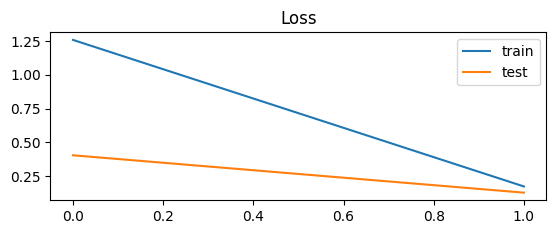

In [32]:
# plot loss during training
%matplotlib inline
plt.subplot(211)
plt.title('Loss')
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='test')
plt.legend()
plt.show()

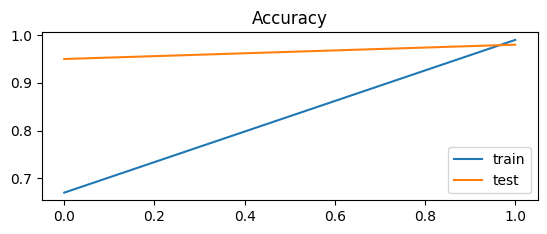

In [33]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(results.history['accuracy'], label='train')
plt.plot(results.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [34]:
model.evaluate(test_ds, return_dict=True)


25/25 [==============================] - 1254s 50s/step - loss: 0.1259 - accuracy: 0.9700


{'loss': 0.12594188749790192, 'accuracy': 0.9700000286102295}

In [42]:
def get_actual_predicted_labels(dataset):
  actual = []
  predicted_prob = []

  for batch in dataset:
        images, labels = batch
        actual.extend(labels.numpy())
        predicted_prob.append(model.predict(images))

  actual = np.array(actual)
  predicted_prob = np.concatenate(predicted_prob, axis=0)
  predicted = np.argmax(predicted_prob, axis=1)

  return actual, predicted, predicted_prob


# **Visualising Data**
## Using a confusion Matrix.

In [43]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  %matplotlib inline
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(6, 6)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

In [44]:
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

In [45]:
def calculate_metrics(actual, predicted):
    precision = precision_score(actual, predicted, average='weighted')
    recall = recall_score(actual, predicted, average='weighted')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    return precision, recall



def plot_roc_curve(actual, predicted_prob, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(actual, predicted_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [47]:
actual, predicted, predicted_prob = get_actual_predicted_labels(test_ds)

1/1 [==============================] - 49s 49s/step


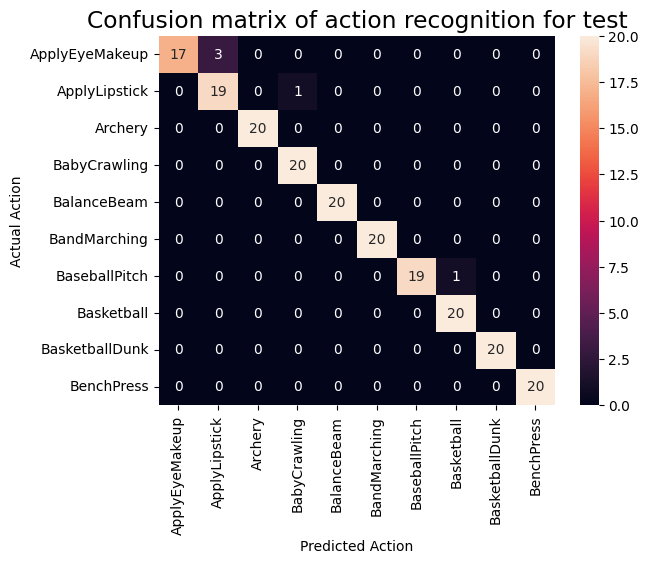

In [48]:
plot_confusion_matrix(actual, predicted, label_names, 'test')

In [49]:
precision, recall = calculate_metrics(actual, predicted)


Precision: 0.976839826839827
Recall: 0.975


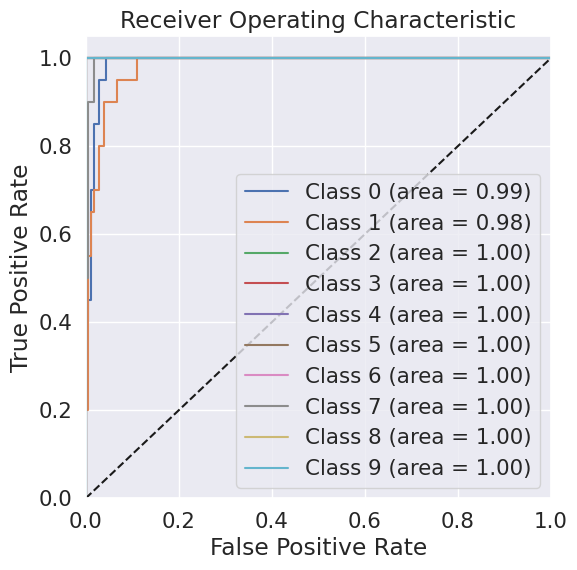

In [50]:
plot_roc_curve(actual, predicted_prob, num_classes=10)

In [54]:
from sklearn.metrics import f1_score

f1 = f1_score(actual, predicted,average='weighted')
print(f1)




0.974925931023492


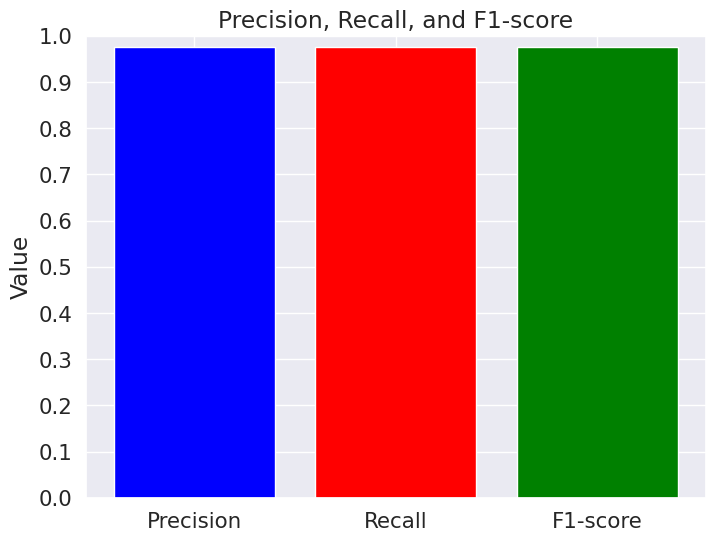

In [59]:
def plot_precision_recall_f1(precision, recall, f1):
    metrics = ['Precision', 'Recall', 'F1-score']
    values = [precision, recall, f1]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['blue', 'red', 'green'])
    plt.ylim(0, 1)
    plt.yticks([0.1*i for i in range(11)])
    plt.ylabel('Value')
    plt.title('Precision, Recall, and F1-score')
    plt.show()


plot_precision_recall_f1(precision, recall,f1)